Ce notebook est destiné à démontrer le fine-tuning d'un modèle BERT pour la prédiction de sentiment des tweets et montrer comment cela peut améliorer les résultats par rapport aux autres notebooks.<br>
Pour cela, j'utilise le modèle `bert-base-uncased`de la librairie `transformers` de Hugging Face.


# Imports

In [1]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import mlflow
import mlflow.tensorflow
import pickle
import time
import dl
import utils
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

2025-01-13 15:06:44.601500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## BERT: Bidirectional Encoder Representations from Transformers

**BERT** (Bidirectional Encoder Representations from Transformers) est un modèle de langage développé par Google en 2018. Conçu pour comprendre le contexte des mots dans une phrase en tenant compte des mots qui les précèdent et les suivent, BERT révolutionne la manière dont les systèmes de traitement automatique du langage (NLP) comprennent et interprètent le texte. 

### Caractéristiques principales

- **Bidirectionnel :** Contrairement aux modèles traditionnels qui analysent le texte de gauche à droite ou de droite à gauche, BERT lit le texte dans les deux sens simultanément. Cette approche bidirectionnelle permet une compréhension plus profonde et plus nuancée du contexte.

- **Basé sur des Transformers :** BERT s’appuie sur l’architecture des Transformers, qui utilise des mécanismes d’attention pour traiter les dépendances entre les mots, quelle que soit leur distance dans le texte.

- **Pré-entraînement et fine-tuning :** 
  - **Pré-entraînement :** BERT est d'abord pré-entraîné sur un vaste corpus de textes non étiquetés (comme Wikipedia) à l’aide de tâches d’apprentissage auto-supervisé. Deux tâches principales sont utilisées : 
    - *Masked Language Modeling* (masquer certains mots dans une phrase pour que le modèle les prédise).
    - *Next Sentence Prediction* (prédire si une phrase suit logiquement une autre).
  - **Fine-tuning :** Ensuite, BERT est affiné sur des tâches spécifiques telles que la classification de texte, l’extraction d’informations ou la réponse à des questions, en ajustant ses paramètres sur un jeu de données annoté.

### Avantages

- **Compréhension contextuelle améliorée :** Grâce à son analyse bidirectionnelle, BERT excelle dans la compréhension du contexte, ce qui améliore la précision dans de nombreuses tâches NLP.
- **Polyvalence :** Une fois pré-entraîné, BERT peut être adapté à une grande variété de tâches avec peu de données supplémentaires et un effort de fine-tuning minimal.

### Ce qui distingue BERT des modèles précédents

- **Contextual Word Embeddings :** Contrairement aux modèles précédents qui attribuaient un seul vecteur à chaque mot, BERT génère des embeddings de mots contextuels qui varient en fonction de leur contexte dans la phrase.
- **Tokenization :** BERT utilise une tokenization WordPiece, qui découpe les mots en sous-mots pour mieux gérer les mots inconnus et améliorer la généralisation. BERT est de ce fait capable d'intérpréter efficacement l'argot et les abréviations utilisées dans les tweets. C'est ce que nous allons démontrer ici.

## Fonctions de transformation pour BERT

J'utilise ces deux fonctions:
- `tokenize_texts` : pour transformer les textes en tokens BERT et ajouter les tokens spéciaux, les masques d'attention et les padding. Je conserve le max_length à 128 comme les mots sont découpés en sous-tokens.
- `transform_data_for_bert` : Convertit les textes en lowercase, les encode en récupérant les indices des tokens dans le vocabulaire de BERT et les masques d'attention.

In [2]:
# Tokenisation et encodage des textes en un format compatible avec BERT
def tokenize_texts(texts, tokenizer, max_length=128):
    """
    Tokenizes a list of texts using the provided tokenizer.

    Args:
        texts (list of str): The texts to be tokenized.
        tokenizer (Tokenizer): The tokenizer to use for tokenizing the texts.
        max_length (int, optional): The maximum length of the tokenized sequences. Defaults to 128.

    Returns:
        dict: A dictionary containing the tokenized texts in tensor format.
    """
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf",
    )

In [3]:
def transform_data_for_bert(X, y, col_name, tokenizer):
    """
    Transforms input data for BERT model.

    This function takes input features and labels, processes the text data using a tokenizer,
    and returns the tokenized input IDs, attention masks, and labels in a format suitable for BERT.

    Args:
        X (pd.DataFrame): DataFrame containing the input features.
        y (pd.Series): Series containing the labels.
        col_name (str): The name of the column in X that contains the text data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for encoding the text data.

    Returns:
        tuple: A tuple containing three elements:
            - input_ids (np.ndarray): Array of tokenized input IDs.
            - attention_masks (np.ndarray): Array of attention masks.
            - labels (np.ndarray): Array of labels.
    """
    # Convertir les données en liste
    texts = (
        X[col_name].str.lower().tolist()
    )  # S'assure que les données sont en minimuscules
    labels = y.tolist()

    # Stocker les transformations avec l'encoder
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenize_texts([text], tokenizer)
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])
    input_ids = np.asarray(input_ids)
    attention_masks = np.asarray(attention_masks)
    labels = np.array(labels)

    # Retourner les données
    return input_ids, attention_masks, labels

## Fine-tuning de BERT

L'expérience consiste ici à fine-tuner un modèle BERT pour la classification de sentiment des tweets. J'utilise le modèle `bert-base-uncased` de la librairie `transformers` de Hugging Face.
Je charge les mêmes données d'entrainement et de test précédemment utilisées pour les autres notebooks.


Le modèle contenant beaucoup de paramètres, je vais uniquement lancer 3 epochs et avec un learning rate 5e-5.<br>
J'utiliserai uniquement les données brutes sans aucune transformation supplémentaire.<br>
L'objectif ici est de montrer que grâce à sa tokenization WordPiece, BERT est capable de bien interpréter les tweets et d'obtenir de bons résultats sans avoir besoin de prétraitement supplémentaire.<br>

In [4]:
# Load the pickle file containing the columns
with open("../data/processed/train_columns.pkl", "rb") as f:
    cols = pickle.load(f)

# Load the parquet file
X_train_full = pd.read_pickle("../data/processed/X_train.pickle")
X_test_full = pd.read_pickle("../data/processed/X_test.pickle")
y_train = pd.read_pickle("../data/processed/y_train.pickle")
y_test = pd.read_pickle("../data/processed/y_test.pickle")


# Set fixed variables
SEED = 314
np.random.seed(SEED)
URI = "http://localhost:5000"

/home/hedredo/miniconda310/envs/p7_tf_cpu/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2025-01-13 15:07:10.807378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 15:07:10.808957: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 

(19036, 1, 128) (4759, 1, 128) (19036,) (4759,) (19036, 1, 128) (4759, 1, 128)


2025/01/13 15:07:19 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.
2025/01/13 15:07:19 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.


Epoch 1/3
744/744 [==============================] - 5363s 7s/step - loss: 0.4292 - accuracy: 0.8047 - val_loss: 0.2869 - val_accuracy: 0.9021
Epoch 2/3
744/744 [==============================] - 5364s 7s/step - loss: 0.2689 - accuracy: 0.8965 - val_loss: 0.1472 - val_accuracy: 0.9498
Epoch 3/3
1/1 [==============================] - 2s 2s/step


2025/01/13 19:33:44 WARNING mlflow.tensorflow: Failed to infer model signature: 'TFSequenceClassifierOutput' object has no attribute '__name__'
2025/01/13 19:33:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpqboiti37/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqboiti37/model/data/model/assets
2025/01/13 19:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Evaluate on validation data
186/186 [==============================] - 467s 2s/step


,negative,positive,macro avg
precision,0.808777,0.854657,0.831717
recall,0.865481,0.794474,0.829978
f1-score,0.836169,0.823468,0.829818
support,2981.000000,2968.000000,5949.000000


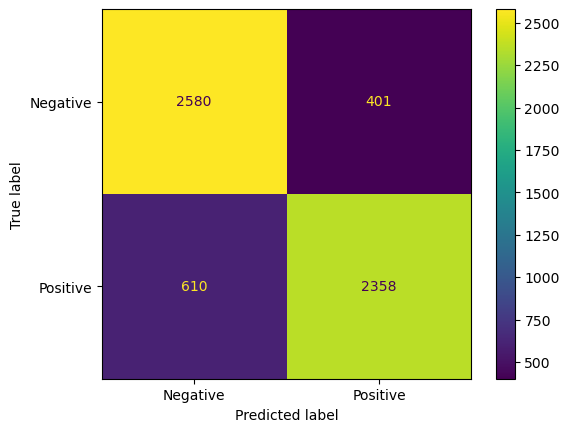

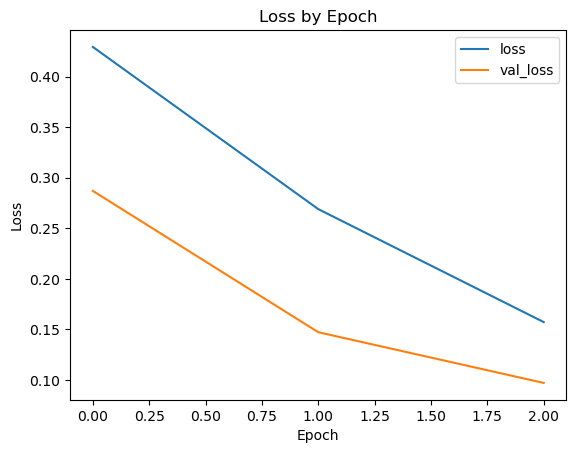

🏃 View run bert_sentiment_classification_raw_text at: http://localhost:5000/#/experiments/15/runs/36de1cc4b008489d97ed41d88f485174
🧪 View experiment at: http://localhost:5000/#/experiments/15


In [7]:
# Define the URI of the MLflow server and the name of the experiment & check if the prepared dataset is in the columns
experiment = "p7_bert_model"

# Set the tracking URI
mlflow.set_tracking_uri(URI)
# try to connect to the server
try:
    mlflow.tracking.get_tracking_uri()
except Exception as e:
    print(f"Cannot connect to the server : {URI}. Check the server status.")
    raise e
# Set, and create if necessary, the experiment
try:
    mlflow.create_experiment(experiment)
except Exception:
    pass
finally:
    mlflow.set_experiment(experiment)


# Charger le tokenizer et le modèle BERT pour la classification
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
col_name = "text"

# Encode le train et le test
train_full_input_ids, train_full_attention_masks, train_full_labels = (
    transform_data_for_bert(X_train_full, y_train, col_name, tokenizer)
)

test_input_ids, test_attention_masks, test_labels = transform_data_for_bert(
    X_test_full, y_test, col_name, tokenizer
)

# Vérifie les tailles
len(train_full_input_ids), len(train_full_attention_masks), len(train_full_labels)
# Séparer les ensembles de données
train_input_ids, val_input_ids, train_labels, val_labels, train_masks, val_masks = (
    train_test_split(
        train_full_input_ids,
        train_full_labels,
        train_full_attention_masks,
        test_size=0.2,
        random_state=314,
    )
)
# Vérifier les formes
print(
    train_input_ids.shape,
    val_input_ids.shape,
    train_labels.shape,
    val_labels.shape,
    train_masks.shape,
    val_masks.shape,
)

# Batch size
batch_size = 32
# Prépare les datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": train_full_input_ids.squeeze(),
            "attention_mask": train_full_attention_masks.squeeze(),
        },
        train_full_labels,
    )
).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": val_input_ids.squeeze(),
            "attention_mask": val_masks.squeeze(),
        },
        val_labels,
    )
).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": test_input_ids.squeeze(),
            "attention_mask": test_attention_masks.squeeze(),
        },
        test_labels,
    )
).batch(batch_size)

# Compile le modèle
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Entraînement du modèle
epochs = 3

# Start the MLflow run & autolog
mlflow.tensorflow.autolog(checkpoint=False, log_models=True, log_datasets=True)
with mlflow.start_run(run_name="bert_sentiment_classification_raw_text") as active_run:
    # Entraine le modèle
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
    )

    # Evaluate the model
    print("Evaluate on validation data")
    print("==============")
    start_time = time.time()
    loss, accuracy = model.evaluate(test_dataset)
    inference_time = time.time() - start_time
    y_pred = model.predict([test_input_ids.squeeze(), test_attention_masks.squeeze()])
    predictions = np.argmax(y_pred.logits, axis=1)
    # Log classification report as artifact on mlflow
    report = classification_report(
        y_test, predictions, output_dict=True, target_names=["negative", "positive"]
    )
    report_df = pd.DataFrame(report).filter(["negative", "positive", "macro avg"])
    display(report_df)
    report_df.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")
    # Use ConfustionMatrixDisplay and save it as png as an artifact on mflow
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test, predictions, display_labels=["Negative", "Positive"]
    )
    cm.figure_.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    # Plot the loss and accuracy by epoch
    dl.plot_loss(history).figure.savefig("loss_by_epoch.png")
    mlflow.log_artifact("loss_by_epoch.png")
    plt.show()
    # Récupère les métriques avec le meilleur val_loss
    best_val_loss = np.array(history.history["val_loss"])
    indice_best_val_loss = int(np.argmin(best_val_loss))
    mlflow.log_metrics(
        {
            "log_loss": loss,
            "val_loss": history.history["val_loss"][indice_best_val_loss],
            "accuracy_score": accuracy,
            "val_accuracy": history.history["val_accuracy"][indice_best_val_loss],
            "inference_time": inference_time,
        }
    )
    mlflow.log_params(
        {
            "data_preparation": col_name,
            "learning_rate": 5e-5,
            "batch_size_": batch_size,
            "standardization": "lowercase",
            "test_size_ratio": 0.2,
            "validation_split_": 0.2,
            "pretrained_weights": model_name,
        }
    )


Les résultats obtenus seront sensiblement meilleurs que ceux obtenus avec les autres notebooks.<br>
Bien que le modèle a fini par overfitter sur les données d'entrainement, il a obtenu une accuracy de 0.83 sur les données de test.<br>
Le gros désavantage du fine-tuning de BERT est le temps de calcul qui est très long à cause du nombre très importants de poids sur le modèle.<br>
Ce type de modèle est aussi beaucoup lourd à déployer et nécessite des ressources importantes pour être utilisé en production.<br>


Voici les résultats de l'expérimention sur l'UI de MLFLOW :

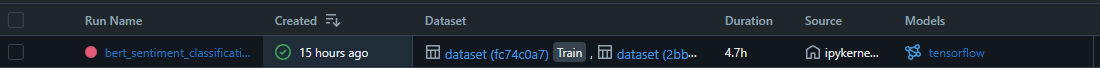

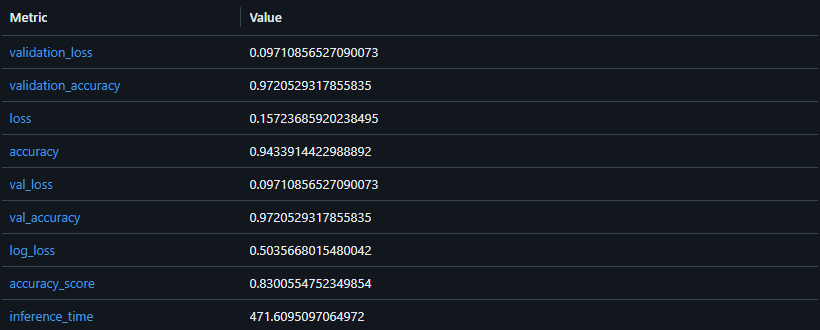

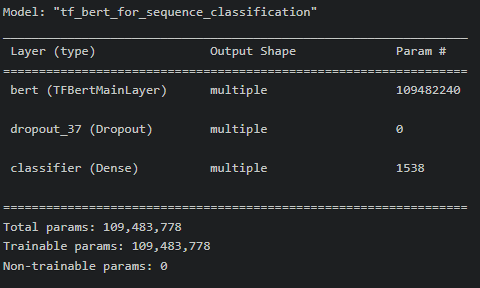

# Comparaison des résultats

Je continue à utiliser l'interface MLFLOW pour montrer différentes visualisations pour comparer les résultats selon les différentes expérimentations en retenant notamment :
- Fine-tuning de BERT
- Modèle TfIdf + Logistic Regression (`suave-perch-35`)
- Neural network from sratch
- Neural network with GloVe-twitter-25
- Neural network with Paragram-25
- Neural network BILSTM

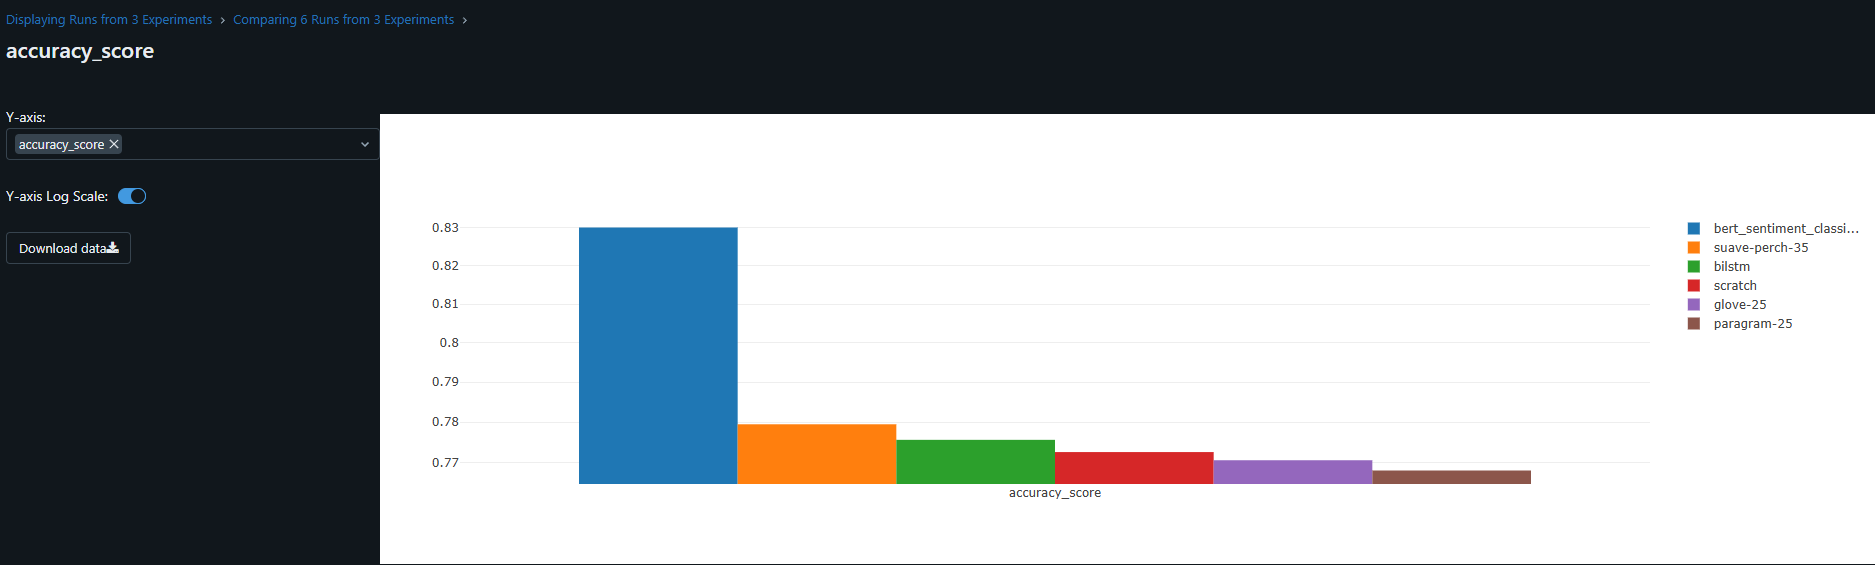

Le fine-tuning de BERT a obtenu le meilleur score d'accuracy sur les données de test et se démarque des autres modèles.<br>
Le modèle TfIdf + Logistic Regression a obtenu un score d'accuracy de 0.78 mais a nécessité un prétraitement supplémentaire notamment avec la tranformation en lemma ainsi que les prétraitements supplémentaires qui sont assez couteuses en temps de calcul.<br>
Les autres modèles de réseaux de neurones ont obtenu des résultats proches et n'ont pas nécessité les lemmes mais quand mêmes des prétraitements supplémentaires pour les embeddings.<br>
L'utilisation de word embeddings n'a pas vraiment amélioré les résultats mais cela n'est pas surprenant vu l'argot utilisé dans les tweets.<br>

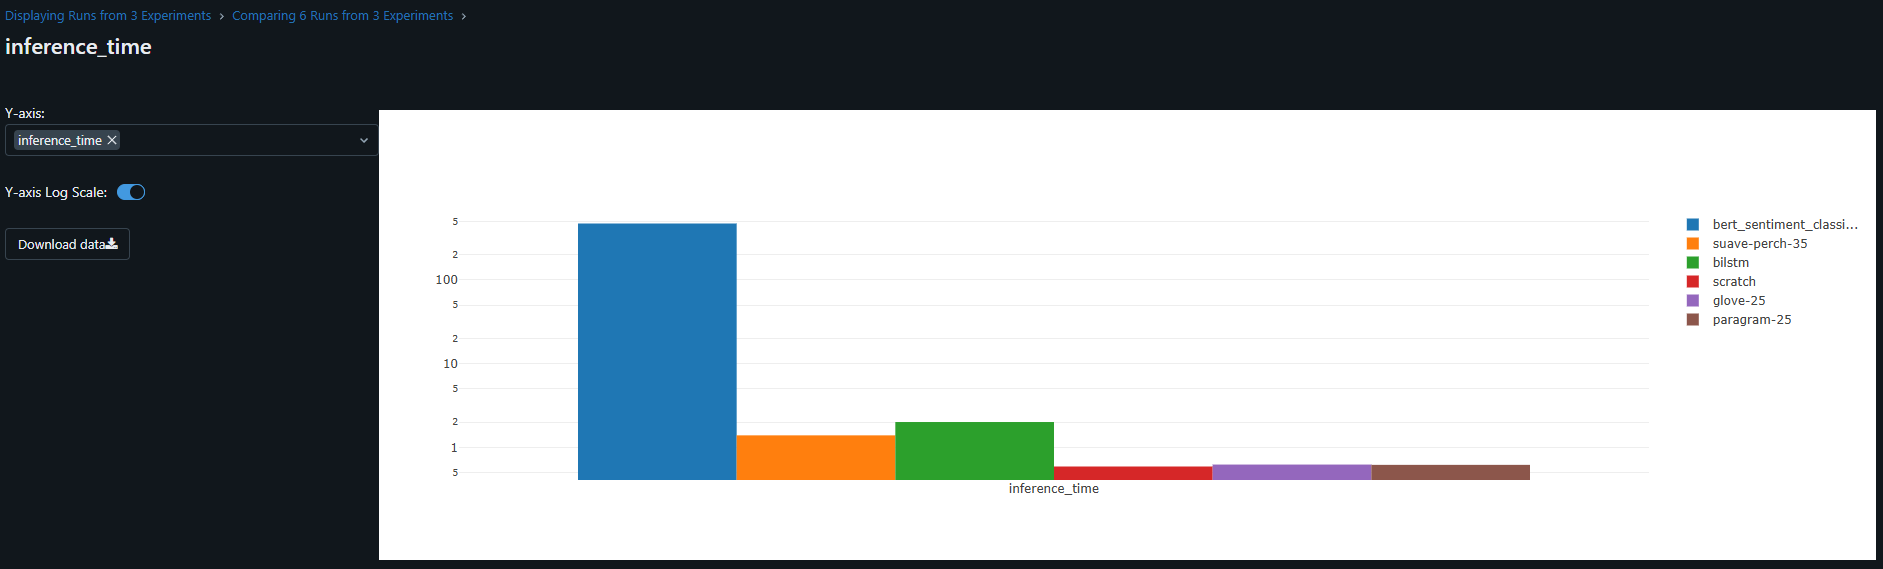

Lorsqu'on compare les temps d'inference, on voit que le fine-tuning de BERT est le plus lent à cause du nombre très important de paramètres à calculer.<br>
Le modèle TfIdf + Logistic Regression avec le modèle BILSTM sont plus longs que les autres modèles mais restent acceptables.<br>
Au final le modèle from sratch est assez rapide, assez léger et a des performances correctes.<br>

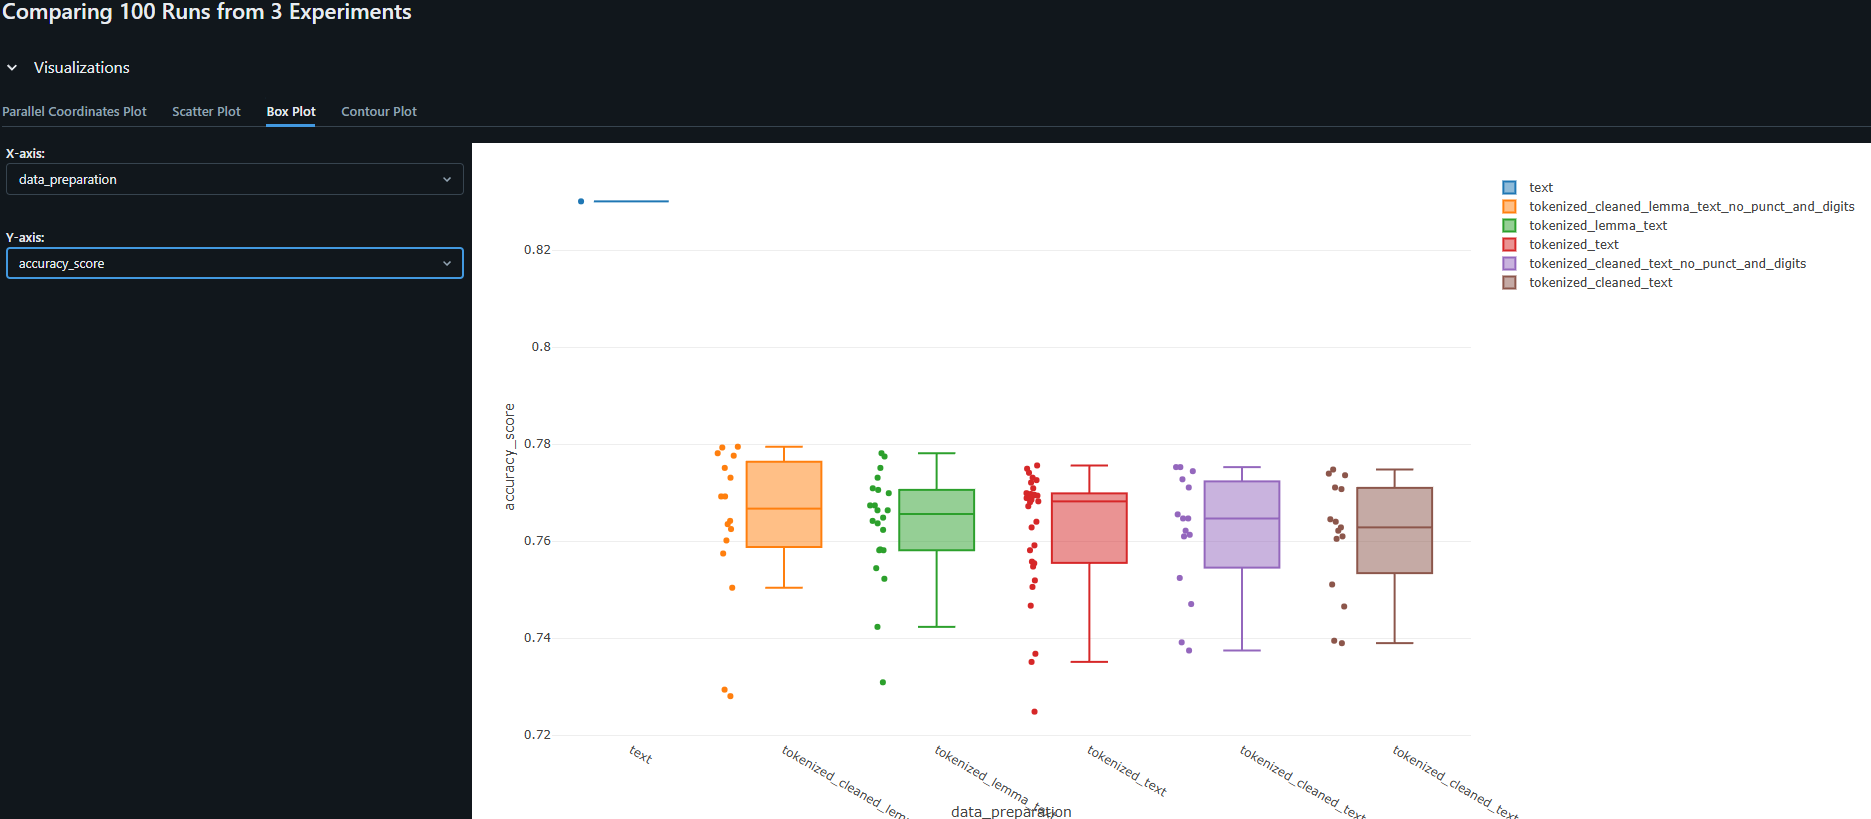

Si on compare les préparations effectuées pour chaque modèle, il n'y a pas forcément de grosse différence entre les jeux de données bien que cela est à nuancer du fait que la lemmatization ait profitement amélioré les résultats du modèle TfIdf + Logistic Regression.<br>
Regardons les spécifiquement les réseaux de neurones qui ont les fonctions de standardisations intégrées dans le modèle :

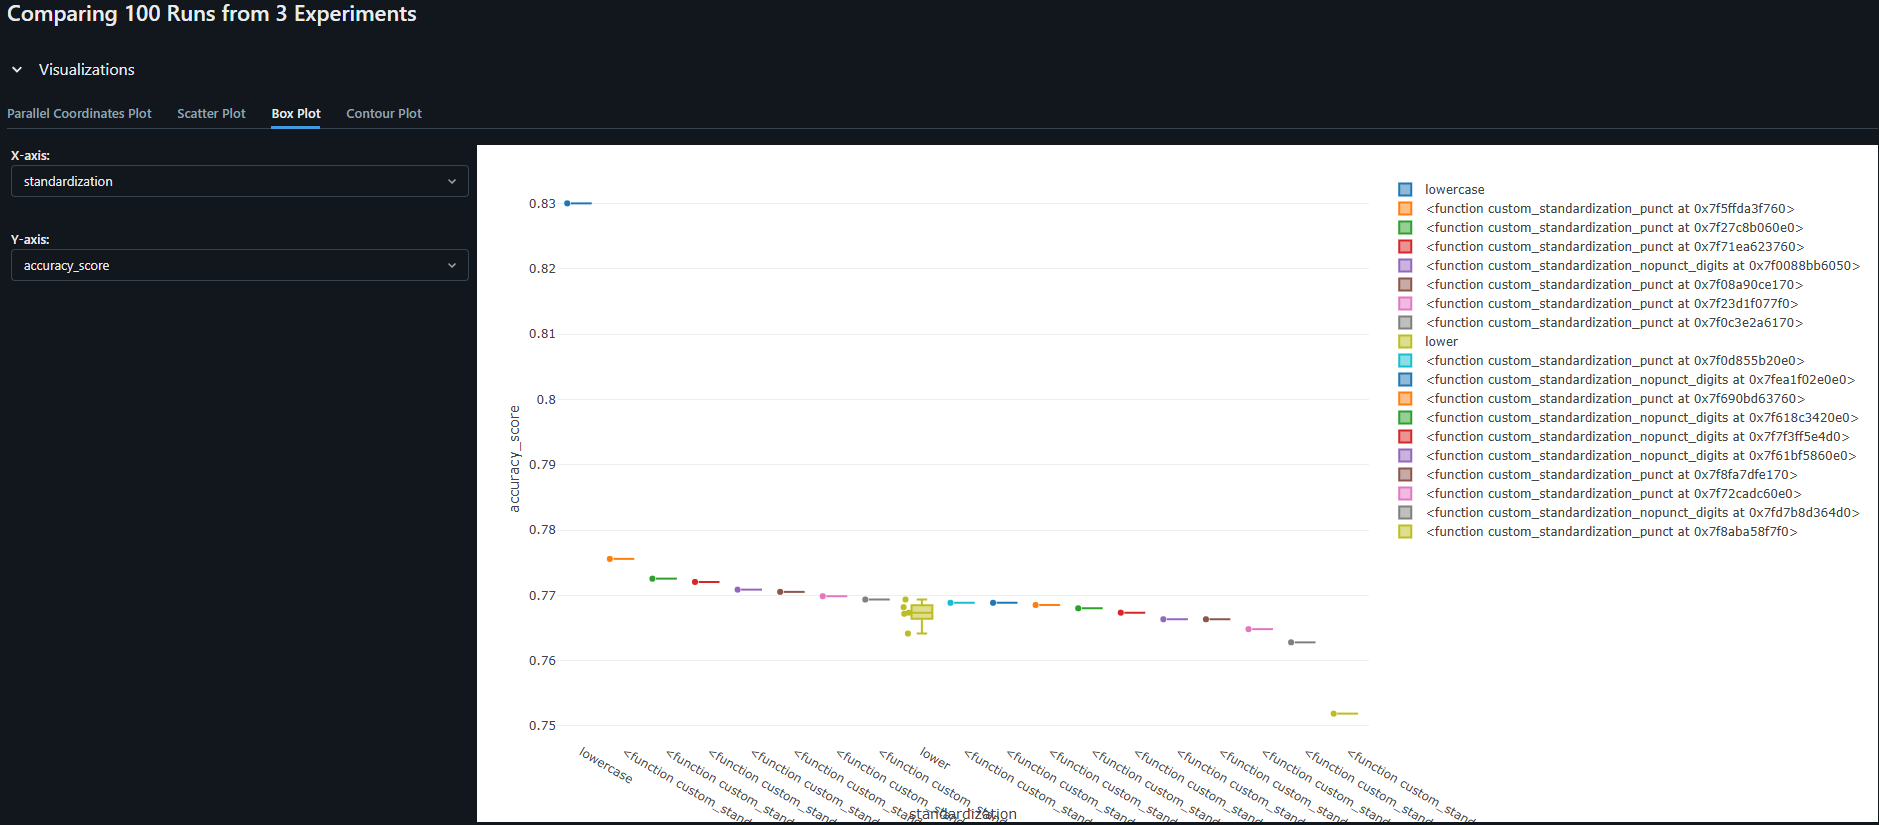

On voit ici que les réseaux de neurones, hormis BERT, ont davantage profité du type de standardisation "légère" (conserve la poncutuation lié au sentimen telle que ?!.) plutôt que celle "agressive" (retrait de la ponctuation et des chiffres en plus).<br>
L'avantage ici est que la fonction de standardisation est intégrée dans la couche de vectorisation, profite des opérations sous forme de tensors et est donc plus rapide.<br>
Cela explique pourquoi les réseaux de neurones ont obtenu de meilleurs résultats avec la standardisation "légère" et pourquoi le modèle TfIdf + Logistic Regression a profité de la lemmatization ainsi que les différences en temps de calcul.<br>
Le modèle TfIdf + Logistic Regression a obtenu de meilleurs résultats avec la lemmatization car il a pu mieux généraliser les mots sur la taille du jeu de données.<br>


Des expérimentations non incluses ici sur des jeux de données plus grands ont montré que les réseaux de neurones, mêmes les plus simples, obtiennent de meilleurs résultats que le TfIdf + Logistic Regression.<br>
Toutefois, pour garder des résultats avec une base de données comparables et "stables" pour tous les modèles, j'ai choisi de ne pas les inclure dans les résultats ici présentés.<br>

Au final, BERT uncased obtient de bien meilleurs résultats sans avoir besoin de prétraitements supplémentaires que du passage en lowercase des textes et avec une taille de jeu de données restreintes.<br>
Il aurait même profité d'ajustement des paramètres et de régularisation pour obtenir de meilleurs résultats mais son temps de calcul est très long et nécessite des ressources importantes pour mener à bien ces expériences supplémentaires.